## 3. Modelo ML para el sistema de recomendación.
Basamos el sistema de recomendacion en un modelo no-supervisado. En este modelo, estimamos la semejanza de caracteristicas de los casos usando la similitud del coseno con base en información cualitativa (texto). Para afrontar las limitaciones de computo locales (intel duo + 8GB RAM) al procesar el tamaño de la informacion cualitativa (35.000+ casos), se clusterizaron los casos con base en una mezcla de variables quantiativas y categoricas. Por tal motivo, implementamos nuestro modelo en dos etapas. En la primera etapa, adoptamos una estrategia de clusterizacion de "arriba-abajo" para definir dos niveles de clusters con base en conocimiento previo. En la segunda etapa, estimamos la semejanza de caracteristicas de los casos mediante la similitud del coseno pero unicamente entre los casos miembros del cluster más bajo (nivel 2). De esta manera, logramos alivianar el procesamiento de datos al disminuir el tamaño de los datos con base en el cual se estima la similitud del coseno.

In [4]:
# librerias para manejo de datos
import psutil
import platform
import os
import glob
import numpy as np
import pandas as pd

# librerias para Kmeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

# librerias para calcular la similitud de cosenos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# otros
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Las caracteristicas de nuestra infrastructura local,
# lo cual pone limitaciones al momento de diseñar e implementar nuestro modelo.
print(platform.platform())
print("RAM:",str(round(psutil.virtual_memory().total / (1024.0 **3))),"GB")

Windows-10-10.0.22631-SP0
RAM: 15 GB


In [6]:
# carga de datos
# quitamos lo valores nulos en 'overview'
data_mvp_ml = pd.read_csv(
    os.path.join('D:\Bootcamp\Henry\CURSO\Proyecto Individual 1\Movies\Output','data_mvp_final_ml.csv'),
    index_col=0).convert_dtypes().dropna() 
print("Universo de peliculas unicas:",data_mvp_ml['movie_id'].nunique(),"\n")

data_mvp_ml.info()
data_mvp_ml.isna().sum()

Universo de peliculas unicas: 35834 

<class 'pandas.core.frame.DataFrame'>
Index: 42056 entries, 0 to 93362
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   runtime            42056 non-null  Int64  
 1   original_language  42056 non-null  string 
 2   title              42056 non-null  string 
 3   release_year       42056 non-null  Int64  
 4   movie_id           42056 non-null  Int64  
 5   prtgnst_gender     42056 non-null  Int64  
 6   prtgnst_nivel      42056 non-null  Int64  
 7   popularity         42056 non-null  Float64
 8   overview           42056 non-null  string 
 9   genres             42056 non-null  string 
 10  vote_average       42056 non-null  Float64
dtypes: Float64(2), Int64(5), string(4)
memory usage: 4.1 MB


runtime              0
original_language    0
title                0
release_year         0
movie_id             0
prtgnst_gender       0
prtgnst_nivel        0
popularity           0
overview             0
genres               0
vote_average         0
dtype: int64

In [7]:
data_mvp_ml.head()

,runtime,original_language,title,release_year,movie_id,prtgnst_gender,prtgnst_nivel,popularity,overview,genres,vote_average
0,81,en,Toy Story,1995,862,2,1,21.946943,"Led by Woody, Andy's toys live happily in his ...",Animation,7.7
2,81,en,Toy Story,1995,862,2,1,21.946943,"Led by Woody, Andy's toys live happily in his ...",Comedy,7.7
4,81,en,Toy Story,1995,862,2,1,21.946943,"Led by Woody, Andy's toys live happily in his ...",Family,7.7
6,104,en,Jumanji,1995,8844,2,1,17.015539,When siblings Judy and Peter discover an encha...,desconocido,6.9
8,101,en,Grumpier Old Men,1995,15602,2,1,11.7129,A family wedding reignites the ancient feud be...,Romance,6.5


### 3.1. Clusterizacion de los casos
En esta etapa definimos los clusters. Como mencionamos anteriormente, adoptamos un estrategia de "arriba-abajo" (tambien conocida como Divisive Clustering). Empezamos con un primer nivel de clusterizacion y luego empleamos un segundo nivel de clusterizacion al interior del primero. En otras palabras, primero agrupamos los casos segun una serie variables "A" que consideramos de mayor importancia, y segundo identificamos subgrupos segun otras variables "B" que consideramos de menor importancia relativo a las variables "A". De esta manera, los clusters "A" adquieren un nivel mas alto de jerarquia sobre los cluster "B".

__Suposiciones en la identificacion de grupos:__

Para el primer nivel de clusters, identificamos grupos segun popularity y release_year. Nuestra intuicion es que el caso mas representativo de una audiencia son personas que prefieren ver peliculas populares (popularity) de una misma epoca (release_year); es decir, consideramos que estos son los dos criterios mas importante al momemento de elegir una pelicula.

Para el segundo nivel, agrupamos casos segun genres, vote_average y prtgnst_gender_strng. Para identificar estos grupos, suponemos que las personas prefieren elegir peliculas (al interior del grupo epoca-popularidad) segun el genero (genres) (p. ej., accion, drama, etc) y segun su calidad dada por el puntaje de los criticos y audiencia (vote_average). Tambien consideramos que las personas estan interesadas en peliculas si la protagonista es mujer (prtgnst_gender_strng).

__Virtud de nuestra estrategia:__

Consideramos que la mayor virtud de nuestra estrategia consiste en alivianar la carga computacional local al momento de calcular la similitud de cosenos.

__Limitaciones:__

Claramente, nuestras suposiciones sobre las preferencias de la audiencia no estan excentas de ser objeto de discusion. Por ejemplo, las personas pueden elegir una pelicula segun su genero (i.e., accion, drama, animada) independiente de la epoca en que fue producida; de igual manera, otras personas pueden privilegiar el actor principal o la casa productora al momento de elegir una pelicula. Pero consideramos que nuestras suposiciones constituyen un punto de partida que puede irse mejorando con la ayuda de mas datos y/o de literatura sobre las preferencias de la audiencia al momeneto de elegir peliculas.

__Pre-procesamiento: Transformaciones__

Previo al proceso de cluterizacion, escalamos todas las variables al rango 0,1. De esta manera, tanto las variables numericas como las categoricas transformadas en dummies (0,1) comparten un mismo rango. Esto garantiza que todas las variables tengan el mismo peso al momento de calcular las distancias de los centroides durante el proceso de clusterizacion.

In [8]:
# definimos nuestro la jerarquia de clusters.
vars_clstr_a=[
    'popularity',
    'release_year'
    ]
vars_clstr_b=[
    'genres',
    'prtgnst_gender',
    #'runtime',
    'vote_average',
    ]
#vars_clstr_c=[ # no fue necesario llegar a un tercer nivel de clusterizacion
    #'franquicia',
    #'director',
    #'executive_producer'
#    ]

### 3.1.1. Clusters: Primer nivel

In [9]:
# nos concentramos en el primer nivel de clusters
# seleccionamos unicamente las variables que nos importan
data_mvp_ml_clstr_a=data_mvp_ml[['movie_id']+vars_clstr_a].drop_duplicates()
print("Numero de peliculas unicas:",data_mvp_ml_clstr_a['movie_id'].nunique(),"\n")
data_mvp_ml_clstr_a.set_index('movie_id', inplace=True)
data_mvp_ml_clstr_a.info()
data_mvp_ml_clstr_a.head(3)

Numero de peliculas unicas: 35834 

<class 'pandas.core.frame.DataFrame'>
Index: 35834 entries, 862 to 227506
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    35834 non-null  Float64
 1   release_year  35834 non-null  Int64  
dtypes: Float64(1), Int64(1)
memory usage: 944.8 KB


,popularity,release_year
movie_id,,
862,21.946943,1995
8844,17.015539,1995
15602,11.7129,1995


In [10]:
# Escalamos las variables al rango 0,1
scaler = preprocessing.MinMaxScaler()
scaler.fit(data_mvp_ml_clstr_a)
data_mvp_ml_clstr_a_scaled=pd.DataFrame(
    scaler.transform(data_mvp_ml_clstr_a),
    index=data_mvp_ml_clstr_a.index).rename(columns={
        0: "popularity_scaled",
        1: "release_year_scaled"#,
        #2:"runtime_scaled"
        })
data_mvp_ml_clstr_a_scaled.head()

,popularity_scaled,release_year_scaled
movie_id,,
862,0.040087,0.810606
8844,0.031079,0.810606
15602,0.021394,0.810606
31357,0.007049,0.810606
11862,0.015320,0.810606


In [11]:
# Identificamos el numero optimo de clusters.
# Tomamos como limite maximo el numero que
# generaria clusters con un promedio de 1000 registros c/u
k_clstr_a_max=int(data_mvp_ml_clstr_a_scaled.shape[0]/1000) # 35

# iniciamos el loop
# SSE corresponde a Suma de distancias al cuadrado;
# es el equivalente al "residual" en regresion lineal.
# Interpretacion de SEE: entre mas bajo, cada registro
# esta mas cerca al centro del cluster mas cercano
sse = [] 
random_state=42
#KMeans(n_clusters=2, random_state=42)
# con k_clstr_a_max generamos clusters con un promedio de 1000 registros c/u.
for k in range(1, k_clstr_a_max): 
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(data_mvp_ml_clstr_a_scaled)
    sse.append(kmeans.inertia_) # este es nuestro SSE

# identificamos el numero optimo de clusters
kl_eval = KneeLocator(
    range(1, k_clstr_a_max),
    sse, curve="convex", direction="decreasing")

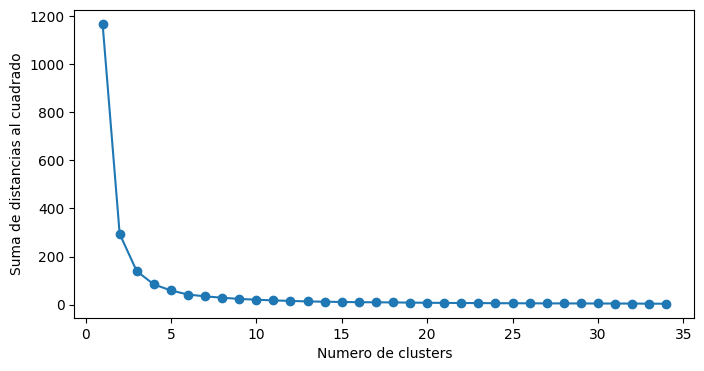

Numero optimo de clusters: 4


In [12]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, k_clstr_a_max), sse, marker='o')
plt.xlabel('Numero de clusters')
plt.ylabel('Suma de distancias al cuadrado')
plt.show()
k_optimo_clstr_a=kl_eval.elbow
print("Numero optimo de clusters:", k_optimo_clstr_a)

In [13]:
# clusterizamos los casos segun el numero optimo de clusters
# que identificamos en el paso anterior

# instanciamos
kmeans_clstr_a = KMeans(n_clusters=k_optimo_clstr_a, random_state=random_state)

# ajustamos
kmeans_clstr_a.fit(data_mvp_ml_clstr_a_scaled)

# asignamos membresia a cluster;
# sumamos 1 que el primer cluster no sea 0
data_mvp_ml_clstr_a_scaled['clstr_a'] = kmeans_clstr_a.predict(
    data_mvp_ml_clstr_a_scaled)+1 
data_mvp_ml_clstr_a_scaled.reset_index(inplace=True)
data_mvp_ml_clstr_a_scaled.info()
data_mvp_ml_clstr_a_scaled.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35834 entries, 0 to 35833
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   movie_id             35834 non-null  Int64  
 1   popularity_scaled    35834 non-null  float64
 2   release_year_scaled  35834 non-null  float64
 3   clstr_a              35834 non-null  int32  
dtypes: Int64(1), float64(2), int32(1)
memory usage: 1015.0 KB


,movie_id,popularity_scaled,release_year_scaled,clstr_a
0,862,0.040087,0.810606,3
1,8844,0.031079,0.810606,3
2,15602,0.021394,0.810606,3
3,31357,0.007049,0.810606,3
4,11862,0.015320,0.810606,3


In [14]:
# codificamos la variable categorica genres mediante la herramient get_dummies
data_mvp_ml_dummies_genres = pd.get_dummies(
    data=data_mvp_ml[
        ['movie_id','genres']].drop_duplicates().set_index('movie_id'),
    columns=['genres'], # genera dummies para cada grupo de valor por columna:
    #drop_first=True, # no es necesario eliminar las variables reduntantes;
    # mas abajo ahondamos en esto
    dtype=float # dummies en valore numerico
    ).reset_index()

# Como nuestro objetivo es medir distancia en un plano multi-dimensional,
# sintetizamos las dummies sobre un mismo eje (fila) por medio de su suma.
# Esta es la razon por la cual arriba no eliminamos las variables reduntantes;
# asi mediamos para cada cada fila (pelicula_id) si sí posee (1) o no posee (0) la caracteristica.
data_mvp_ml_dummies_genres = data_mvp_ml_dummies_genres.groupby(
    'movie_id').sum().reset_index() 
print(data_mvp_ml_dummies_genres['movie_id'].nunique())
print(data_mvp_ml_dummies_genres.shape[0])
data_mvp_ml_dummies_genres.loc[data_mvp_ml_dummies_genres['movie_id']==862]

35834
35834


,movie_id,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,...,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,genres_desconocido
678,862,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# generamos dummies para la variable categorica: genero de protagonista
data_mvp_ml_dummies_prtgnst = pd.get_dummies(
    data=data_mvp_ml[
        ['movie_id','prtgnst_gender']
        ].drop_duplicates().set_index('movie_id'),
    columns=['prtgnst_gender'], # genera dummies para cada grupo por columna:
    drop_first=True, # removemos las dummies redunantes
    dtype=float # dummies en valore numerico
    ).reset_index()
print(data_mvp_ml_dummies_prtgnst['movie_id'].nunique())
print(data_mvp_ml_dummies_prtgnst.shape[0])
data_mvp_ml_dummies_prtgnst.loc[data_mvp_ml_dummies_prtgnst['movie_id']==862]

35834
35836


,movie_id,prtgnst_gender_1,prtgnst_gender_2
0,862,0.0,1.0


In [16]:
# nos concentramos en la variable de interes
data_mvp_ml_clstr_b_vote = data_mvp_ml[
    ['movie_id','vote_average']].drop_duplicates().set_index('movie_id')
data_mvp_ml_clstr_b_vote_array = data_mvp_ml_clstr_b_vote.to_numpy()
data_mvp_ml_clstr_b_vote.head(3)

,vote_average
movie_id,
862,7.7
8844,6.9
15602,6.5


In [17]:
# escalamos la variable de interes
scaler.fit(data_mvp_ml_clstr_b_vote_array)
data_mvp_ml_clstr_b_vote_scaled=pd.DataFrame(
    scaler.transform(data_mvp_ml_clstr_b_vote_array),
    index=data_mvp_ml_clstr_b_vote.index).rename(
        columns={0: 'vote_average_scaled'}).reset_index()
print(data_mvp_ml_clstr_b_vote_scaled['movie_id'].nunique())
print(data_mvp_ml_clstr_b_vote_scaled.shape[0])
data_mvp_ml_clstr_b_vote_scaled.head(3)

35834
35834


,movie_id,vote_average_scaled
0,862,0.77
1,8844,0.69
2,15602,0.65


In [18]:
data_mvp_ml_clstr_b=pd.merge(pd.merge(pd.merge(
    data_mvp_ml_clstr_b_vote_scaled,
    data_mvp_ml_dummies_genres,
    on='movie_id',
    how='left'),
    data_mvp_ml_dummies_prtgnst,
    on='movie_id'),
    data_mvp_ml_clstr_a_scaled[ # anexamos la membresia al cluster A
        ['movie_id','clstr_a']].drop_duplicates(),
    on='movie_id',
    how='left')#.set_index('movie_id')

# resultado
print(data_mvp_ml_clstr_b['movie_id'].nunique())
print(data_mvp_ml_clstr_b.shape[0])
data_mvp_ml_clstr_b=data_mvp_ml_clstr_b.set_index('movie_id')
data_mvp_ml_clstr_b.head(3)

35834
35836


,vote_average_scaled,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,...,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,genres_desconocido,prtgnst_gender_1,prtgnst_gender_2,clstr_a
movie_id,,,,,,,,,,,,,,,,,,,,,
862,0.77,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
8844,0.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3
15602,0.65,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3


In [19]:
k_clstr_b_max=round(max(data_mvp_ml_clstr_b['clstr_a'].value_counts())/1000)
print(data_mvp_ml_clstr_b['clstr_a'].value_counts())
print("Numero max de clusters (promedio de 1000 registros por subcluster):",
      k_clstr_b_max)

clstr_a
2    18071
3     8144
4     6010
1     3611
Name: count, dtype: int64
Numero max de clusters (promedio de 1000 registros por subcluster): 18


In [20]:
# creamos un lista con los clusters unicos de la primera fase de clusterizacion
list_clstr_a=list(np.sort(data_mvp_ml_clstr_b['clstr_a'].unique()))
print(list_clstr_a)

[np.int32(1), np.int32(2), np.int32(3), np.int32(4)]


In [21]:
# en esta etapa, evaluamos el numero optimo
# de subclusters (nivel 2) para cada cluster (nivel 1)

# creamos un diccionario para ir recogiendo
# el numero optimo de subclusters para cada cluster
clstr_b_k_dict = {'clstr_a':[],'k_optimo':[]}

# iniciamo el loop para cada cluster nivel 1
for i in list_clstr_a:
    random_state=42
    #i=1
    data_mvp_ml_clstr_b_loop=data_mvp_ml_clstr_b.loc[data_mvp_ml_clstr_b['clstr_a']==i]

    sse = [] 
    for k in range(1, k_clstr_b_max):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(data_mvp_ml_clstr_b_loop)
        sse.append(kmeans.inertia_)

    # identificamos el numero optimo de subclusters (nivel 2)
    kl = KneeLocator(
        range(1, k_clstr_b_max),
        sse, curve="convex", direction="decreasing")
    k_optimo_clstr_b=kl.elbow
    clstr_b_k_dict['clstr_a'].append(i)
    clstr_b_k_dict['k_optimo'].append(k_optimo_clstr_b)

# generamos un dataframe con el numero optimo de cluster_b para cada cluster_a 
input_k_clstr_b = pd.DataFrame(data=clstr_b_k_dict)
input_k_clstr_b

,clstr_a,k_optimo
0,1,4
1,2,4
2,3,4
3,4,4


In [22]:
# creamos un df para recoger la asignacion de subclusters para cada caso (registro)
# usamos el index de pelicula_id para asignar los subclusters
# col_2drop es variable basura para instancia un df vacio
data_mvp_ml_clstr_b_2concat = pd.DataFrame(
    {'col_2drop':[999 for i in range(data_mvp_ml_clstr_b.shape[0])]},
    index=data_mvp_ml_clstr_b.index)

# iniciamos el loop para cada cluster nivel 1 para asignar sub clusters a cada pelicula 
for i in list_clstr_a:
    random_state=42
    #i=1
    data_mvp_ml_clstr_b_loop = data_mvp_ml_clstr_b.loc[
        data_mvp_ml_clstr_b['clstr_a']==i].drop(columns=['clstr_a'])
    k_optimo = int(input_k_clstr_b['k_optimo'].loc[input_k_clstr_b['clstr_a']==i])
    kmeans_clstr_b = KMeans(n_clusters=k_optimo, random_state=random_state)
    kmeans_clstr_b.fit(data_mvp_ml_clstr_b_loop)
    
    
    data_ml_clstr_b=pd.DataFrame(
        {'clstr_b':kmeans_clstr_b.predict(data_mvp_ml_clstr_b_loop)+1},
        index=data_mvp_ml_clstr_b_loop.index)
    data_ml_clstr_b['clstr_a']=i
    data_mvp_ml_clstr_b_2concat = pd.concat(
        [data_mvp_ml_clstr_b_2concat, data_ml_clstr_b], axis=0)
data_mvp_ml_clstr_b_label = data_mvp_ml_clstr_b_2concat.loc[
    data_mvp_ml_clstr_b_2concat['col_2drop']!=999].drop(columns=['col_2drop'])
print("Sub-cluster con el numero de registros mas alto:",
      max(data_mvp_ml_clstr_b_label[['clstr_a','clstr_b']].value_counts()))
data_mvp_ml_clstr_b_label.info()
data_mvp_ml_clstr_b_label.head(3)

Sub-cluster con el numero de registros mas alto: 8531
<class 'pandas.core.frame.DataFrame'>
Index: 35836 entries, 408 to 67179
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   clstr_b  35836 non-null  float64
 1   clstr_a  35836 non-null  float64
dtypes: float64(2)
memory usage: 874.9 KB


,clstr_b,clstr_a
movie_id,,
408,2.0,1.0
10895,1.0,1.0
26744,1.0,1.0


In [23]:
# universo de clusters y sub-clusters y su tamaño
print(data_mvp_ml_clstr_b_label.sort_values(
    by=['clstr_a','clstr_b']).groupby(['clstr_a','clstr_b']).value_counts())

# confirmamos que nuestra estrategia de asignacion de clusters
# ha sido consistente manteniendo el numero de registros en la base de datos
print("\nNumero de peliculas unicas:",data_mvp_ml_clstr_b_label.sort_values(
    by=['clstr_a','clstr_b']).groupby('clstr_a').value_counts().sum())

clstr_a  clstr_b
1.0      1.0        1867
         2.0         987
         3.0         197
         4.0         560
2.0      1.0        8531
         2.0        4333
         3.0        1785
         4.0        3422
3.0      1.0        4386
         2.0        1154
         3.0        1566
         4.0        1038
4.0      1.0        3352
         2.0        1093
         3.0         514
         4.0        1051
Name: count, dtype: int64

Numero de peliculas unicas: 35836


### 3.2. Calculo de similitud de cosenos

In [24]:
# creamos un dataframe para estimar la similitud de cosenos
data_mvp_ml_cosine=pd.merge(
    data_mvp_ml[['movie_id','overview']].drop_duplicates(),
    data_mvp_ml_clstr_b_label.reset_index(),
    on='movie_id',
    how='left').dropna()
data_mvp_ml_cosine.info()
data_mvp_ml_cosine.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35836 entries, 0 to 35835
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   movie_id  35836 non-null  Int64  
 1   overview  35836 non-null  string 
 2   clstr_b   35836 non-null  float64
 3   clstr_a   35836 non-null  float64
dtypes: Int64(1), float64(2), string(1)
memory usage: 1.1 MB


,movie_id,overview,clstr_b,clstr_a
0,862,"Led by Woody, Andy's toys live happily in his ...",4.0,3.0
1,8844,When siblings Judy and Peter discover an encha...,1.0,3.0
2,15602,A family wedding reignites the ancient feud be...,4.0,3.0
3,31357,"Cheated on, mistreated and stepped on, the wom...",3.0,3.0
4,11862,Just when George Banks has recovered from his ...,4.0,3.0
